In [1]:
import os
import numpy as np
import pickle as pc
import tensorflow as tf
from utils import *

#from seq2seq import *
from LSTM import *

In [2]:
LBNL_DATA_DIR = 'data/LBNL Building 74/lbnlb74electricity.xlsx'
horizon_size = 96
best_loss = 100000000.0
lr = 0.0001
batch_size = 1
max_patience = 7
max_epochs = 100
checkpoint_dir = 'lstm2_checkpoint'
LOG_INTERVAL = 200
keep_rate = 0.5
hidden_unit = 16
num_layer = 1

debug = False

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
def evaluate():
    # data load
    time, elec = load_data(LBNL_DATA_DIR)
    
    # modify
    elec = missing_value(elec)
    print(elec[40226])
    
    elec = std_normalize(elec)
    
    # split data
    train, valid, test = split_dataset(elec)
    
    # build dataset
    test_observe, test_pred = lstm_build_dataset(test, horizon_size)
    print("Build Dataset Finished")
    print("[Test] enc {}\tdec {}".format(len(test_observe), len(test_pred)))
    
    # model
    lstm = LSTM(hidden_unit, keep_rate)
    
    # optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    # loss & metric obj
    loss_obj = tf.keras.losses.MeanSquaredError()
    rmse_obj = tf.keras.metrics.RootMeanSquaredError()
  
    # ckpt dir
    checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                     lstm=lstm)
    #latest_ckpt = tf.train.latest_checkpoint(ckpt_dir)
    best_ckpt_dir = os.path.join(checkpoint_dir, 'best_lr-{}_hidden-{}_hr-{}'.format(lr, hidden_unit, horizon_size))
    latest_ckpt = tf.train.latest_checkpoint(best_ckpt_dir)
    print("latest ckpt: {}".format(latest_ckpt))
    checkpoint.restore(latest_ckpt)
    
    
    num_batches_per_epoch = (len(test_observe)-1) // batch_size + 1
    print("num_batches_per_epoch: {}".format(num_batches_per_epoch))
    
    test_batches = batch_iter(test_observe, test_pred, batch_size)

    test_loss = list()
    preds = list()
    trues = list()
    
    for batch_idx, (batch_x, batch_y) in enumerate(test_batches):

        logits = lstm(batch_x, training=False)

        preds.extend(tf.reshape(logits, [-1]).numpy())
        trues.extend(tf.reshape(batch_y, [-1]).numpy())
        
        loss = loss_obj(batch_y, logits)

        rmse_obj.update_state(batch_y, logits)
        test_loss.append(np.mean(loss))

    print("loss: {:.4f} RMSE: {:.4f}".format(np.mean(test_loss), rmse_obj.result().numpy()))
    rmse_obj.reset_states()

    return trues, preds

In [4]:
def show_plot(time_step, true, pred, title):
    import matplotlib as mpl
    import matplotlib.pylab as plt
    %matplotlib inline
    
    marker = ['.-', 'r-']
    
    plt.title(title)
    plt.figure(figsize=(30, 10))
    plt.plot(time_step[5000:5500], true[5000:5500], marker[0], label='True')
    plt.plot(time_step[5000:5500], pred[5000:5500], marker[1], label='Pred')
    plt.legend()
    plt.xlabel('Time-step')
    return plt

/usr/local/lib/python3.6/dist-packages/openpyxl/worksheet/_reader.py:292: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Size of time, elec: 46111	46111
43.899
Mean: 31.535117450933615	Std: 8.103161225783838
Size of train, valid, test: 27973	6994	11144
Build Dataset Finished
[Test] enc 11048	dec 11048


W1208 12:38:08.354153 139838466549568 base_layer.py:1772] Layer lstm is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



latest ckpt: lstm2_checkpoint/best_lr-0.0001_hidden-16_hr-96/best_ckpt_4-4
num_batches_per_epoch: 11048


W1208 12:39:45.100320 139838466549568 util.py:144] Unresolved object in checkpoint: (root).optimizer.iter
W1208 12:39:45.100827 139838466549568 util.py:144] Unresolved object in checkpoint: (root).optimizer.beta_1
W1208 12:39:45.101286 139838466549568 util.py:144] Unresolved object in checkpoint: (root).optimizer.beta_2
W1208 12:39:45.101699 139838466549568 util.py:144] Unresolved object in checkpoint: (root).optimizer.decay
W1208 12:39:45.102105 139838466549568 util.py:144] Unresolved object in checkpoint: (root).optimizer.learning_rate
W1208 12:39:45.102502 139838466549568 util.py:152] A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/alpha/guide/checkpoints#

loss: 1.6781 RMSE: 1.2954


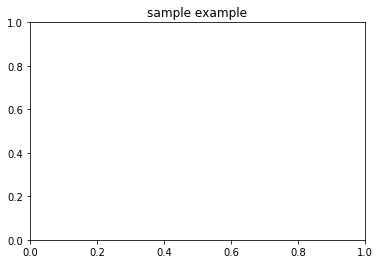

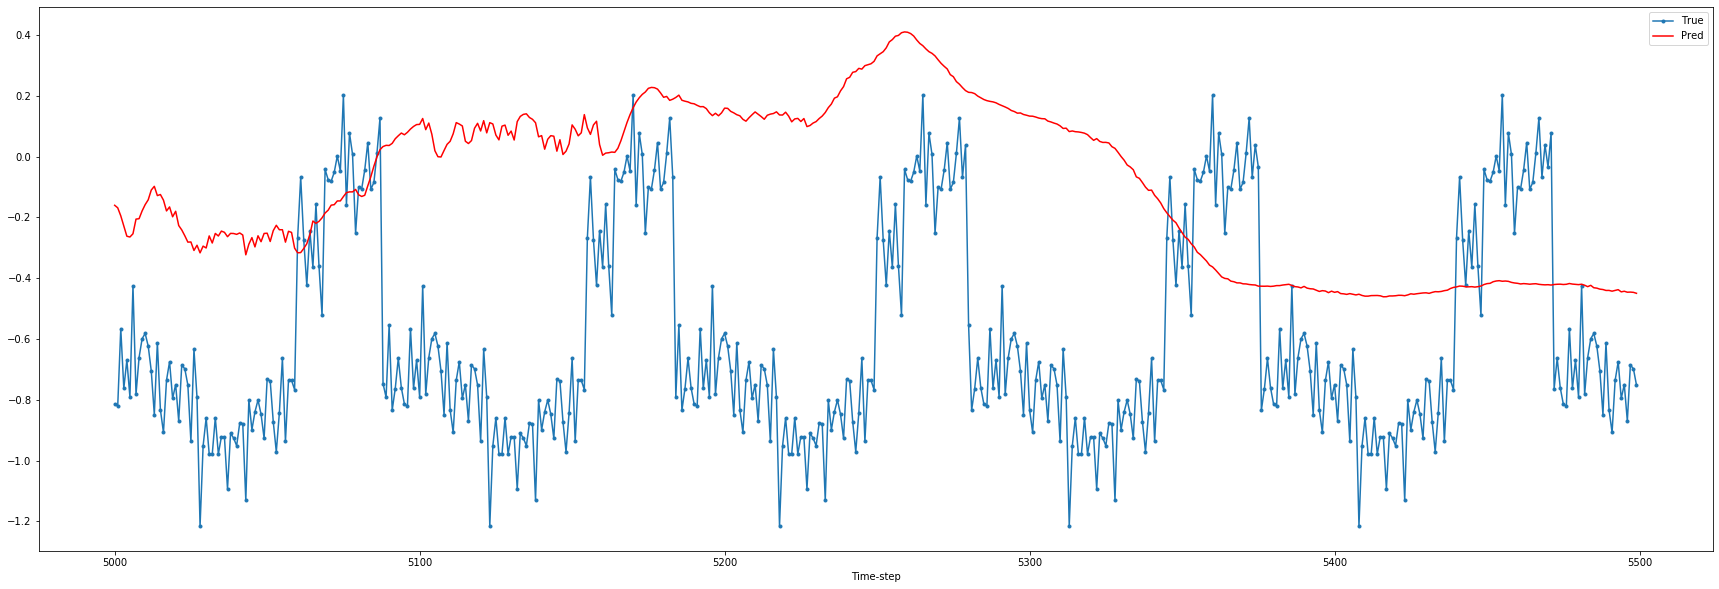

In [5]:
if __name__ == '__main__':
    true, pred = evaluate()
    
    time_step = list()
    for i in range(len(true)):
        time_step.append(i)
    with open('lstm2_pred_{}_{}'.format(horizon_size, hidden_unit), 'wb') as f:
        pc.dump([time_step, true, pred], f)
    show_plot(time_step, true, pred, "sample example")